-------------------
Data Pre Processing
-------------------

Loading Libraries

In [3]:
#importing libraries
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
import ast
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import noisereduce as nr
warnings.filterwarnings("ignore", category=RuntimeWarning)

Feature Extraction Functions

In [2]:
#extracting mfcc

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    #print(file_name)
    reduced_audio = nr.reduce_noise(y=audio, sr=sample_rate)
    mfccs_features = librosa.feature.mfcc(y=reduced_audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [ ]:
# Perform noise reduction
reduced_audio = nr.reduce_noise(y=audio, sr=sr)

Reading Meta Data File

In [5]:
audio_dataset_path='C:/Users/oceanvue/Desktop/DeepShip Dataset/'
metadata=pd.read_csv('../metadata-detailed.csv')
metadata.head()

,Recording ID,File_name,Folder_ID,Class_ID,Class,File_path,Ship Name,Date of Recording,Time of Recording,Durations (s),Distance (m)
0,1,1.wav,1,1,Cargo,Cargo\1\1.wav,SEASPAN SWIFT,20171104,203623,458,1583-1981
1,2,2.wav,2,1,Cargo,Cargo\2\2.wav,ISTRA ACE,20171104,223241,441,1535-1779
2,3,3.wav,3,1,Cargo,Cargo\3\3.wav,SAMOS WARRIOR,20171105,84406,297,642-1520
3,4,4.wav,4,1,Cargo,Cargo\4\4.wav,NYK REMUS,20171106,115234,331,1579-1906
4,5,5.wav,5,1,Cargo,Cargo\5\5.wav,SEASPAN RELIANT,20171107,452,208,477-1241


Iterating through the audio files using metadata file in order to extract features from each audio file.

In [6]:
# Initialize a list to store extracted features and labels
extracted_features = []

# Iterate through metadata and extract features
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), row['Class'], str(row['Folder_ID']), row['File_name']) #getting the filename to send for feature extraction

    final_class_label = row['Class'] #getting the class label of audio file
    data = features_extractor(file_name) #sending file for mfcc extraction
    extracted_features.append([data, final_class_label]) #appending the received features and class label to datagrame

609it [35:34,  3.50s/it]


In [27]:
extracted_features

In [13]:
extracted_features_df_for_csv = pd.DataFrame(extracted_features, columns=["Features", "Class"])

extracted_features_df_for_csv

,Features,Class
0,"[-932.2881, 13.635875, 1.8276811, 4.505561, 1....",Cargo
1,"[-953.34406, 23.712738, 5.6353164, 7.229023, 1...",Cargo
2,"[-896.3549, 26.114866, 8.032627, 10.994141, 4....",Cargo
3,"[-958.41956, 12.191271, 1.7338899, 1.9386969, ...",Cargo
4,"[-896.8744, 49.558216, 24.255026, 20.094505, 1...",Cargo
...,...,...
604,"[-974.24023, 2.3665962, 0.19154242, 1.5096675,...",Tug
605,"[-938.0368, 5.373568, 1.8666614, 0.8558346, 0....",Tug
606,"[-956.2245, 6.7470174, -0.27839443, 1.7886881,...",Tug
607,"[-960.537, -9.796723, 5.7901726, 3.475453, -5....",Tug


Saving extracted features to csv

In [14]:
#extracted_features_df_for_csv['Features'] = extracted_features_df_for_csv['Features'].apply(lambda x: x.tolist()) #to same the extracted features in exact format
extracted_features_df_for_csv['Features'] = extracted_features_df_for_csv['Features'].apply(lambda x: ','.join(map(str, x)))

extracted_features_df_for_csv.to_csv('data_sample_extracted_noise_red.csv', index=False)

Generating a sample heatmap of mfcc coefficients

In [15]:
mfcc_array = np.array(extracted_features_df_for_csv['Features'].tolist())
mfcc_array = mfcc_array.reshape(-1)  # Reshape to 1D array

plt.figure(figsize=(10, 6))
sns.heatmap(mfcc_array, cmap='viridis', annot=False, xticklabels=False, yticklabels=False)
plt.title('MFCC Heatmap')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Samples')
plt.show()

In [16]:
mfcc_array = np.array(extracted_features_df_for_csv['Features'].tolist())
mfcc_array = mfcc_array.reshape(-1)  # Reshape to 1D array

plt.figure(figsize=(10, 6))
sns.heatmap(mfcc_array.reshape(1, -1), cmap='viridis', annot=False, xticklabels=False, yticklabels=False)
plt.title('MFCC Heatmap')
plt.xlabel('MFCC Coefficients')

---------------
Model Pre Work
---------------

Loading Libraies

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

Loading Dataset

In [4]:
ex_data = pd.read_csv(r'./data_sample_extracted_noise_red.csv')
ex_data['Features'] = ex_data['Features'].apply(lambda x: list(map(float, x.split(','))))

In [5]:
ex_data

,Features,Class
0,"[-932.2881, 13.635875, 1.8276811, 4.505561, 1....",Cargo
1,"[-953.34406, 23.712738, 5.6353164, 7.229023, 1...",Cargo
2,"[-896.3549, 26.114866, 8.032627, 10.994141, 4....",Cargo
3,"[-958.41956, 12.191271, 1.7338899, 1.9386969, ...",Cargo
4,"[-896.8744, 49.558216, 24.255026, 20.094505, 1...",Cargo
...,...,...
604,"[-974.24023, 2.3665962, 0.19154242, 1.5096675,...",Tug
605,"[-938.0368, 5.373568, 1.8666614, 0.8558346, 0....",Tug
606,"[-956.2245, 6.7470174, -0.27839443, 1.7886881,...",Tug
607,"[-960.537, -9.796723, 5.7901726, 3.475453, -5....",Tug


Splitting Features

In [6]:
X=np.array(ex_data['Features'].tolist())
y=np.array(ex_data['Class'].tolist())

In [7]:
print('mfcc Features       : ',X.shape)
print('Class Labels shape  : ',y.shape)

mfcc Features       :  (609, 40)
Class Labels shape  :  (609,)


In [8]:
X_copy_1 = X
y_copy_1 = y

X_copy_2 = X
y_copy_2 = y

In [9]:
#label encoding the class labels of y_copy_1

label_encoder = LabelEncoder()
y_copy_1 = label_encoder.fit_transform(y)

In [10]:
y_copy_1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X_copy_1,y_copy_1,test_size=0.2,random_state=0)

In [26]:
X_test

array([[-9.56502500e+02,  4.45939900e+00,  3.96129160e+00, ...,
         5.26133400e-01,  6.06229250e-01,  1.35178160e-01],
       [-9.18785300e+02,  2.41164900e+01,  5.96756640e-02, ...,
         6.61435900e-01,  7.74208070e-01,  9.92941600e-01],
       [-9.32873800e+02,  3.43862460e+01,  1.24659650e+01, ...,
         1.03055330e+00,  6.05297600e-01,  7.81642700e-01],
       ...,
       [-8.66937600e+02,  3.10620670e+01,  8.38586400e-01, ...,
         9.16596830e-01, -6.48454100e-02,  3.67324950e-02],
       [-9.24480700e+02,  7.63614600e-01,  3.34505900e+00, ...,
         6.98121960e-01,  7.15963100e-01,  1.19171776e-01],
       [-9.62628600e+02,  4.97976100e+00,  3.17668560e-01, ...,
         7.68911100e-01,  1.07794740e+00,  7.26504200e-01]])

Technique to handle imbalance data

In [82]:
# Create a list to store indices of samples from each category
category_indices = {category: np.where(y == category)[0] for category in np.unique(y)}

# Calculate the minimum number of samples across all categories
min_samples = min(len(indices) for indices in category_indices.values())

# Initialize lists to store train and test indices
train_indices = []
test_indices = []

# Define the fixed portion (percentage) for training and testing
train_portion = 0.8
test_portion = 0.2

In [83]:
# Iterate through each category
for category, indices in category_indices.items():
    # Select a fixed number of samples from each category
    num_samples = min_samples
    num_train_samples = int(train_portion * num_samples)
    num_test_samples = int(test_portion * num_samples)

    # Randomly shuffle the indices for each category
    shuffled_indices = np.random.permutation(indices)

    # Select samples for training and testing
    train_indices.extend(shuffled_indices[:num_train_samples])
    test_indices.extend(shuffled_indices[num_train_samples:num_train_samples + num_test_samples])


In [84]:
# Split the data using the selected train and test indices
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [19]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [86]:
y_train

array(['Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo',
       'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Cargo', 'Passenger',
       'Passenger', 'Passenger', 'Passenger', 'Passenger', 'Passenger',
       'Passenger', 'Passenger', 'Passenger', 'Passenger', 'Passenger',
       'Passenger', 'Passenger', 'Passenger', 'Passenger', 'Passenger',
       'Passenger', 'Passenger', 'Passenger', 'Passenger', 'Passenger',
       'Passenger', 'Passenger', 'Passenger', 'Passenger', 'Passenger',
       'Passenger', 'Passenger', 'Passenger', 'Passenger', 'Passenger',
    

In [12]:
# Count the occurrences of each category
category_count = Counter(y_train)

# Print the total count of each category
for category, count in category_count.items():
    print(f'{category}: {count}')

2: 189
0: 84
1: 158
3: 56


-----------------------
Machine Learning Models
-----------------------

---------
SVM

Loading Libraries

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report

Defining Parameters for SVM

In [14]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.1, 1, 10] 
}

In [30]:
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=4, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

Fitting 4 folds for each of 9 candidates, totalling 36 fits


Testing Accuracy for SVM

In [32]:
test_accuracy = best_svm_model.score(X_test, y_test)

print("Best Parameters  ::", best_params)
print("Test Accuracy    ::", test_accuracy)

Best Parameters  :: {'svm__C': 10, 'svm__gamma': 0.1}
Test Accuracy    :: 0.6475409836065574


Confusion Matrix

Text(70.72222222222221, 0.5, 'Truth')

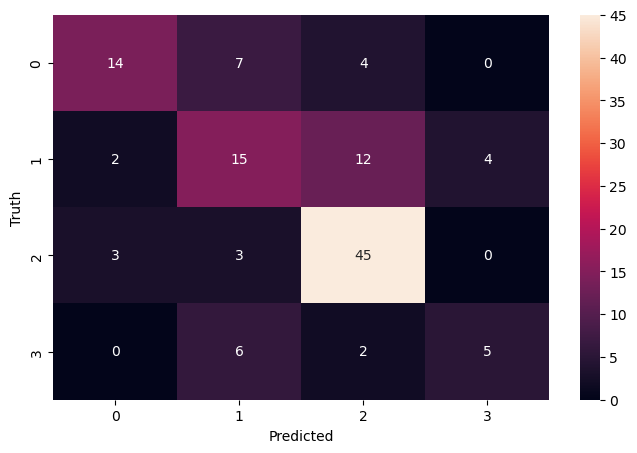

In [33]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))
plt.figure(figsize = (8,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

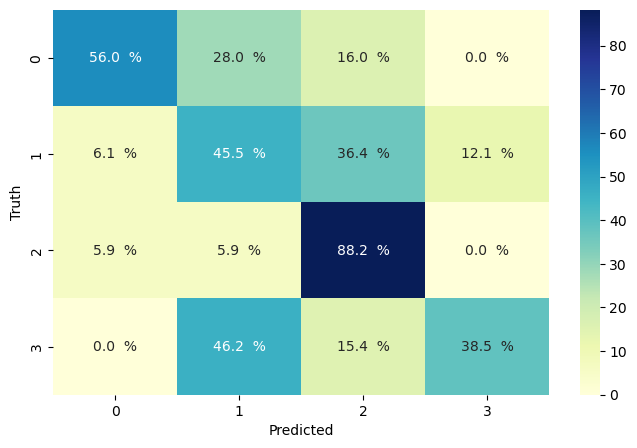

In [35]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))

cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 5))
sn.heatmap(cm_percent, annot=True, fmt=".1f", cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

ax = plt.gca()
for t in ax.texts:
    t.set_text(t.get_text() + "  %")
plt.show()

Precision & Recall

In [34]:
print(classification_report(y_test, grid_search.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.74      0.56      0.64        25
           1       0.48      0.45      0.47        33
           2       0.71      0.88      0.79        51
           3       0.56      0.38      0.45        13

    accuracy                           0.65       122
   macro avg       0.62      0.57      0.59       122
weighted avg       0.64      0.65      0.64       122



In [111]:
X_test

array([[-4.64658295e+02,  1.28595749e+02,  1.01827402e+01, ...,
         7.17186809e-01,  2.99746013e+00,  1.81882119e+00],
       [-3.87223602e+02,  1.03982079e+02,  3.97561669e+00, ...,
         1.94586623e+00,  1.00929797e+00,  2.14922667e+00],
       [-3.78800415e+02,  1.05399879e+02,  2.29888477e+01, ...,
        -1.02577710e+00,  3.25005621e-01,  7.07390487e-01],
       ...,
       [-5.25560913e+02,  7.62880630e+01, -9.80636626e-02, ...,
         3.29030228e+00,  5.28957224e+00,  3.84839487e+00],
       [-4.79941193e+02,  8.59962616e+01, -6.87532872e-02, ...,
         1.71654212e+00,  3.47529554e+00,  2.40912676e+00],
       [-3.59434784e+02,  9.18851776e+01,  4.88475990e+00, ...,
         3.53486037e+00, -2.99074888e-01,  2.14804411e+00]])

---------
Decision Tree

-----------------------
Deep Learning Models
-----------------------

--------------
Basic ANN Model

Importing Libraries

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [37]:
## No of classes
num_labels=y_copy_1.shape[0]
num_labels

609

Creating Model --- Needs to understand this one

In [16]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
y_train_encoded

array([2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 3, 1, 3, 2, 1, 1, 2,
       2, 1, 0, 1, 2, 3, 0, 1, 1, 2, 0, 1, 2, 1, 0, 2, 2, 0, 2, 0, 3, 0,
       2, 0, 1, 3, 2, 1, 2, 1, 2, 2, 0, 3, 2, 2, 2, 2, 1, 1, 2, 3, 1, 1,
       2, 2, 1, 2, 2, 1, 1, 3, 1, 1, 1, 0, 0, 1, 1, 2, 2, 1, 3, 2, 2, 1,
       2, 3, 2, 2, 2, 1, 1, 1, 0, 2, 2, 0, 3, 1, 2, 2, 2, 1, 2, 3, 2, 2,
       2, 1, 2, 0, 2, 1, 3, 3, 3, 2, 2, 1, 3, 1, 0, 0, 0, 1, 0, 0, 2, 0,
       1, 0, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2, 2, 1, 1, 1, 0,
       3, 3, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2, 2, 0, 1, 2, 1, 2, 3, 0,
       1, 1, 2, 3, 1, 1, 3, 1, 0, 2, 2, 3, 3, 1, 3, 1, 2, 2, 2, 1, 1, 1,
       3, 2, 1, 0, 2, 0, 0, 2, 3, 2, 2, 2, 0, 3, 3, 2, 2, 1, 1, 1, 0, 2,
       3, 2, 2, 1, 2, 0, 0, 2, 1, 3, 1, 1, 1, 2, 2, 1, 2, 3, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 3, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 0, 0, 1, 0, 2, 2,
       0, 1, 2, 3, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2, 2, 2, 3,
       1, 0, 2, 3, 1, 2, 2, 1, 1, 0, 2, 2, 2, 1, 3,

In [22]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train_encoded, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test_encoded), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
 1/16 [>.............................] - ETA: 10s - loss: 227.4800 - accuracy: 0.1250
Epoch 1: val_loss improved from inf to 14.12121, saving model to saved_models\audio_classification.hdf5
16/16 [==============================] - 1s 46ms/step - loss: 111.5837 - accuracy: 0.3368 - val_loss: 14.1212 - val_accuracy: 0.2049
Epoch 2/100
 1/16 [>.............................] - ETA: 0s - loss: 46.5188 - accuracy: 0.4375

C:\Users\oceanvue\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 14.12121 to 5.61323, saving model to saved_models\audio_classification.hdf5
16/16 [==============================] - 0s 6ms/step - loss: 72.9697 - accuracy: 0.2936 - val_loss: 5.6132 - val_accuracy: 0.2951
Epoch 3/100
 1/16 [>.............................] - ETA: 0s - loss: 52.5978 - accuracy: 0.3750
Epoch 3: val_loss did not improve from 5.61323
16/16 [==============================] - 0s 3ms/step - loss: 51.8093 - accuracy: 0.3265 - val_loss: 6.2902 - val_accuracy: 0.2049
Epoch 4/100
 1/16 [>.............................] - ETA: 0s - loss: 40.6058 - accuracy: 0.2812
Epoch 4: val_loss improved from 5.61323 to 3.62657, saving model to saved_models\audio_classification.hdf5
16/16 [==============================] - 0s 7ms/step - loss: 38.3752 - accuracy: 0.3121 - val_loss: 3.6266 - val_accuracy: 0.3197
Epoch 5/100
 1/16 [>.............................] - ETA: 0s - loss: 33.7973 - accuracy: 0.2812
Epoch 5: val_loss improved from 3.62657 to 2.05317, saving 

Testing Model Performance

Classification Report

In [25]:
X_test

array([[-9.56502500e+02,  4.45939900e+00,  3.96129160e+00, ...,
         5.26133400e-01,  6.06229250e-01,  1.35178160e-01],
       [-9.18785300e+02,  2.41164900e+01,  5.96756640e-02, ...,
         6.61435900e-01,  7.74208070e-01,  9.92941600e-01],
       [-9.32873800e+02,  3.43862460e+01,  1.24659650e+01, ...,
         1.03055330e+00,  6.05297600e-01,  7.81642700e-01],
       ...,
       [-8.66937600e+02,  3.10620670e+01,  8.38586400e-01, ...,
         9.16596830e-01, -6.48454100e-02,  3.67324950e-02],
       [-9.24480700e+02,  7.63614600e-01,  3.34505900e+00, ...,
         6.98121960e-01,  7.15963100e-01,  1.19171776e-01],
       [-9.62628600e+02,  4.97976100e+00,  3.17668560e-01, ...,
         7.68911100e-01,  1.07794740e+00,  7.26504200e-01]])

In [23]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Decode labels
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred_classes)

# Print classification report
print(classification_report(y_test_decoded, y_pred_decoded))

4/4 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        33
           2       0.42      1.00      0.59        51
           3       0.00      0.00      0.00        13

    accuracy                           0.42       122
   macro avg       0.10      0.25      0.15       122
weighted avg       0.17      0.42      0.25       122



c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Accuracy

In [24]:
test_accuracy=model.evaluate(X_test,y_test_encoded,verbose=0)
print(test_accuracy[1])

0.41803279519081116


Confusion Matrix

Text(70.72222222222221, 0.5, 'Truth')

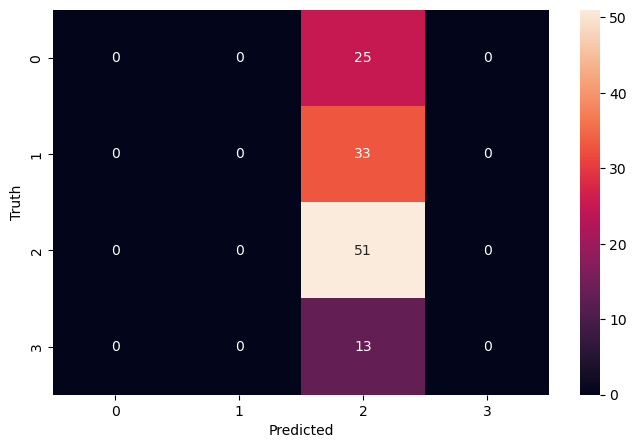

In [26]:
cm = confusion_matrix(y_test_decoded, y_pred_decoded)
plt.figure(figsize = (8,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

---------------
Unseen Data Testing
---------------